In [1]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()

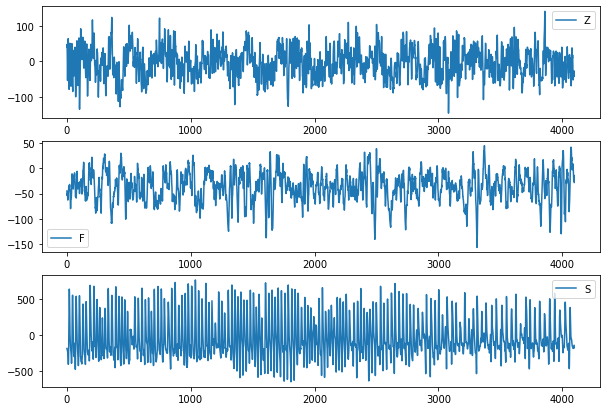

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [3]:
from cesium.featurize import featurize_time_series as ft
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                   "skew",
                   "max_slope"]

fset_cesium = ft(times = eeg["times"],
                 values = eeg["measurements"],
                 errors = None,
                 features_to_use = features_to_use,
                 scheduler = None)

In [4]:
#what does the data look like?
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


In [ ]:
import numpy as np
np.std(eeg["measurements"][0])
np.mean(eeg['measurements'][0])

#### RF sklearn code sample

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg["classes"], random_state=21)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth = 3,
                                random_state = 21)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [6]:
rf_clf.score(X_test, y_test)

0.616

### clustering

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd
import numpy as np
import pdb


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score

#from dtaidistance import dtw
from collections import Counter
from scipy.stats import pearsonr

In [23]:
# data
words = pd.read_csv('worddata.csv',header = None)
words.head()

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.589370,-0.543420,...,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,...,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,...,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,...,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,...,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030


Text(0.5, 0.98, 'Sample word projections and histograms of the projections')

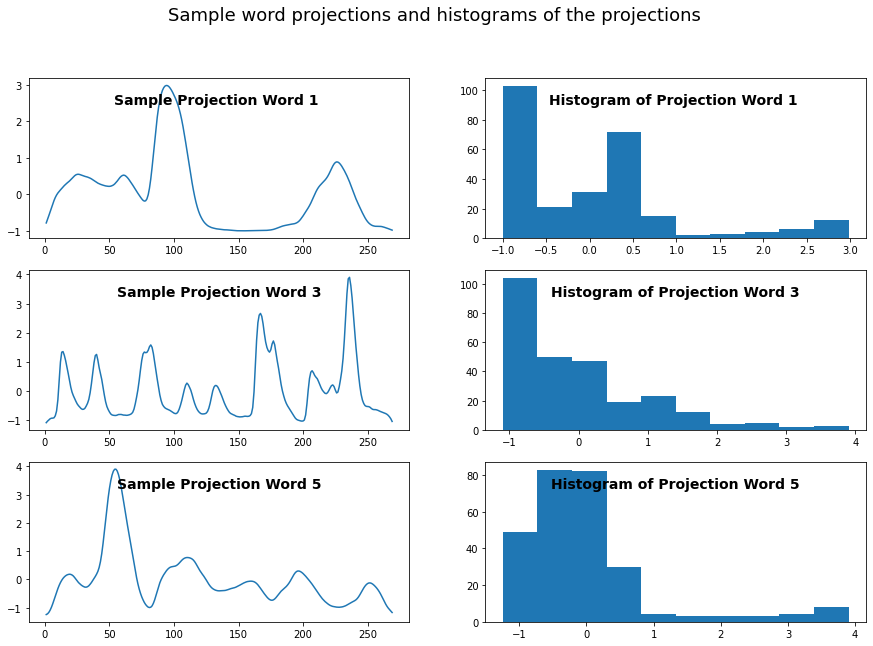

In [25]:
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word 1 ", fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of Projection Word 1 ", fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word 3", fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of Projection Word 3", fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word 5", fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of Projection Word 5", fontweight = 'bold', y = 0.8, fontsize = 14)
plt.suptitle("Sample word projections and histograms of the projections", fontsize = 18)

In [ ]:
words.shape

In [26]:
words_features = words.iloc[:, 1:271]

In [27]:
# creating a time series with a given data
times  = []
values = []
for idx, row in words_features.iterrows():
    values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

In [28]:
from cesium import featurize

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                   ]
featurized_words = featurize.featurize_time_series(times=times,
                                              values=values,
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler = None)
featurized_words.to_csv('./featurized_words.csv')

In [29]:
featurized_words = pd.read_csv("./featurized_words.csv", header =  [0, 1])
featurized_words.columns = featurized_words.columns.droplevel(-1)
featurized_words.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median
0,0,1.674555,0.188889,0.451852
1,1,1.990520,0.118519,0.259259
2,2,2.903650,0.114815,0.637037
3,3,2.515050,0.211111,0.562963
4,4,1.966150,0.181481,0.533333


(array([ 48., 146., 100.,  45.,  41.,  29.,  23.,  12.,   8.,   3.]),
 array([0.05925926, 0.10666667, 0.15407407, 0.20148148, 0.24888889,
        0.2962963 , 0.3437037 , 0.39111111, 0.43851852, 0.48592593,
        0.53333333]),
 <BarContainer object of 10 artists>)

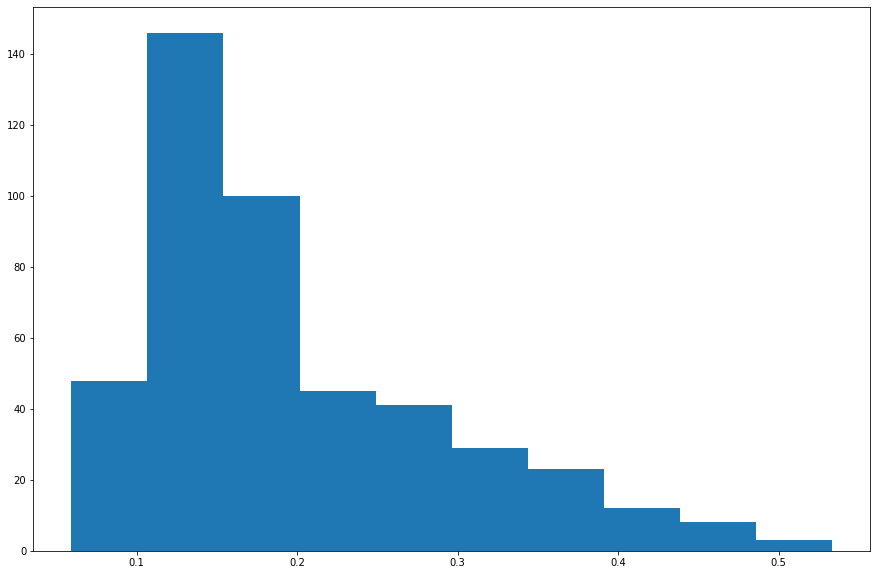

In [30]:
plt.hist(featurized_words.percent_beyond_1_std)

In [31]:
## the number of feature labels 
results = words.groupby('word')['feature_label'].agg(num_clustering_labels=lambda x: len(set(x)),
                                                    num_word_samples=lambda x: len(x),
                                                    most_common_label=lambda x: Counter(x).most_common(1)[0][0])
results.head()

KeyError: 'word'

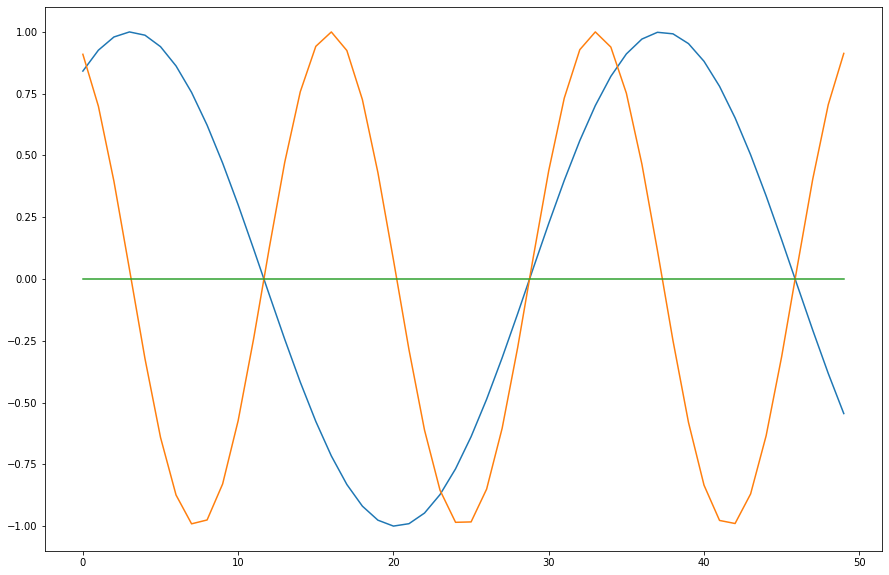

In [32]:
# dynamic time warping distance definition 
ts1 = np.sin(np.linspace(1, 10))
ts2 = np.sin(2 * np.linspace(1, 10))
ts3 = np.zeros((50,)) 
plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)